In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from torchvision import transforms

import torch
from mpl_toolkits import mplot3d

from scipy.optimize import curve_fit
from PIL import Image

from scipy.special import softmax
import imageio
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')
import networkx as nx

In [26]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    
    #emb without void node
    
    x=x[1:]
    y=y[1:]
    t=t[1:]
    
    #############
    
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            #A[i,0]=1.5  ####
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x #x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    
    
    z=1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    
    if z < 0.01:
        z=0.01
    
    
    
    return z



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):

def fit_func(x,a,b):
    return a*x+b

def fingerprint_emb(pos_x,pos_y,window,t,run,void_node=True,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
    im = blend(run,t)#Image.open(path).convert('L') # Can be many different formats.
    im_crop = im.crop((x_l, y_l, x_r, y_u))
     
    if t==9 and run==95:
        im_crop.show()
    foo = im_crop.resize((10,10),Image.ANTIALIAS)

    imarray = np.asarray(foo)
    imarray=imarray.flatten()/255
    return imarray



def fingerprint_wrap(window,run,void=False):
    pos_x,pos_y,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    l=len(pos_x)-1
    
    
    f_e = np.array([np.zeros(100)])


    for k in range(int(np.max(t))+1):
        path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        if k==0:
            pos_x_n=pos_x_n[1:]
            pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            imarray=norm_im_array(np.array([fingerprint_emb(pos_x_n[j],pos_y_n[j],window,k,run)]),offset=8.745098039215686292e-01)
            f_e=np.concatenate((f_e, imarray), axis=0)
            
    
    if void==False:
        f_e=f_e[1:]
            
        
    return f_e
    
    
def blend(run,t):
    
    
    
    pathm1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t-1)+'.png'
    path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t)+'.png'
    pathp1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t+1)+'.png'
    
    
    im = Image.open(path).convert('L')
    shape = np.asarray(im).shape
    
    #print(pixels.shape)
    try:
        imm1 = Image.open(pathm1).convert('L')
        pixels = np.asarray(imm1)
        #print(pixels)
        pixels = pixels.astype('float32')
        pixels = pixels/2
        #pixels = pixels.astype('int')
        imm1 = Image.fromarray(pixels).convert('L')
    except:
        pix=255*np.ones(shape)
        pix = pix.astype('float32')
        pix = pix/2
        imm1 = Image.fromarray(pix).convert('L')
        
    try:
        imp1 = Image.open(pathp1).convert('L')
    except:
        pix=255*np.ones(shape)
        imp1 = Image.fromarray(pix).convert('L')
    
    
    
    im3 = Image.blend(imm1, imp1, 0.5)
    im4 = Image.blend(im3, im, 0.5)
    #im4.show()
    return im4
    
    

def norm_im_array(arr,offset):
    return (arr-offset)*10
    
    
    
'''
pos_x=[5.926355409057428858e-01,4.604170197372819962e-01,6.250962551422760416e-02,1.223613241454796496e-01,6.376507269405902179e-01,1.103583087228645621e-01,4.233227679149828004e-01]
pos_y=[5.378065857159227692e-01,5.482527480620434934e-01,1.628245440499290486e-01,8.255699686855265673e-01,5.184511465256566032e-01,1.492480151352687523e-01,5.115442664966730613e-01]
pix_x=[87,72,27,33,92,32,68]
pix_y=[70,69,113,37,72,114,73]


plt.errorbar(pos_y, pix_y,fmt='.')   

popt, pcov = curve_fit(fit_func, pos_y,pix_y)

plt.plot(pos_y, fit_func(np.array(pos_y),*popt))
print(popt)
'''

a_y=-114.14194117
a_x=113.89266922
b_y=131.3404747
b_x=19.51478307
    
def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    pix_x0=int(fit_func(pos_x,a_x,b_x))
    
    pix_y0=int(fit_func(pos_y,a_y,b_y))
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)

def spectral_embedding(B,d):
    B=symmetrize_matrix(B)
    
    D=np.zeros(B.shape)
    
    column_sums = np.sum(B, axis=0)
    np.fill_diagonal(D, column_sums)
    
    L = D-B
    
    X = k_eigenvectors(L, d)
    
    X=2*np.random.rand(X.shape[0],X.shape[1])-1
    
    
    return X


def symmetrize_matrix(matrix):
    row, col = matrix.shape
    for i in range(row):
        for j in range(i, col):
            matrix[j][i] = matrix[i][j]
    return matrix    
    
    
def k_eigenvectors(matrix, k):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
    return eigenvectors[:, :k]    
    

    
def pos_enc(p,n):
    E=np.zeros((p,n))
    for k in range(int(p/2)):
        for i in range(n):
            E[2*k,i]=np.sin(2*i*np.exp(-(k*np.log(1000))/(p)))
            E[2*k+1,i]=np.cos(2*i*np.exp(-(k*np.log(1000))/(p)))
            
    return E

def fingerprint_cnn(pos_x,pos_y,window,t,run,void_node=False,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    
    if void_node:
        pos_x = 0.74
        pos_y = 0.8
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
        
        path='/home/mo/Desktop/IWR/TimeGraph2.0/void.png'
        
        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        
        im_crop = im.crop((x_l, y_l, x_r, y_u))

        if t==9 and run==95:
            im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        
        imarray = np.asarray(im_crop)
        

        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(imarray)
        im_tens[2]=convert_tensor(imarray)
        
    
    else:
        
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)


        pathm1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t-1)+'.png'
        path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t)+'.png'
        pathp1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t+1)+'.png'


        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        try:
            im_m = Image.open(pathm1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_m = Image.fromarray(pix).convert('L')
        try:
            im_p = Image.open(pathp1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_p = Image.fromarray(pix).convert('L')





        im_crop = im.crop((x_l, y_l, x_r, y_u))
        im_m_crop = im_m.crop((x_l, y_l, x_r, y_u))
        im_p_crop = im_p.crop((x_l, y_l, x_r, y_u))






        if t==9 and run==95:
            im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
        im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)

        imarray = np.asarray(im_crop)
        print('shape',imarray.shape)
        im_m_array = np.asarray(im_m_crop)
        im_p_array = np.asarray(im_p_crop)


        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(im_m_array)
        im_tens[2]=convert_tensor(im_p_array)

    return im_tens

def fingerprint_cnn_wrap(window,run,void=False):
    pos_x,pos_y,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    
    
    
    



    for k in range(int(np.max(t))+1):
        path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        void_tens=fingerprint_cnn(0,0,window,k,run,void_node=True)
        tensor_list = [void_tens]
        if k==0:
            pos_x_n=pos_x_n[1:]
            pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            im_tens=fingerprint_cnn(pos_x_n[j],pos_y_n[j],window,k,run)
            tensor_list.append(im_tens)
            
        #void_tens=fingerprint_cnn(pos_x_n[j],pos_y_n[j],window,k,run,void_node=True)
        #tensor_list.append(void_tens)    
        stacked_tensor = torch.stack(tensor_list)
        
        
        torch.save(stacked_tensor, '/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(k)+'.pt')

        
        
def edge_list_conv(path):
    edge_list = []
    max_n = [1]

    with open(path, 'r') as f:
        for line in f:
            parts = line.split()
            edge_list.append((int(parts[0]), int(parts[1]), int(parts[2])))
            #edge_list.append((int(parts[1]), int(parts[0]), int(parts[2])))
            max_n.append(int(parts[1]))
    print(max_n)
    num_nodes=np.max(max_n)
    return edge_list,num_nodes

def RAPID():#(path_start,p_len,run,d=50):
    # Create a weighted graph
    d=50
    p_len=10
    G = nx.Graph()
    path_start='/home/mo/Desktop/IWR/TimeGraph2.0/node2vec/graph/7.edgelist'
    edge_list,num_nodes=edge_list_conv(path_start)
    
    G.add_weighted_edges_from(edge_list)
    
    f_mat=np.random.rand(num_nodes, d)
    

    for j in range(1,num_nodes+1):
        

        # Perform a random walk with restart from node 1
        start_node = j
        current_node = start_node
        path = [current_node]

        for i in range(p_len):
            print('c',current_node)
            # Compute the probabilities of moving to neighboring nodes
            #probs = np.zeros(len(G.nodes))
            probs=[]
            for neighbor in G.neighbors(current_node):
                print(neighbor)
                #probs[neighbor-1] = G[current_node][neighbor]['weight']
                probs.append(G[current_node][neighbor]['weight'])

            # Normalize the probabilities
            probs /= np.sum(probs)

            print(probs)

            # Choose the next node to visit based on the probabilities
            current_node = np.random.choice(list(G.neighbors(current_node)), p=probs)

            # Add the node to the path
            path.append(current_node)

        print(path)
        counts = {}

        for item in path:
            if item in counts:
                counts[item] += 1
            else:
                counts[item] = 1

        print(counts)

#(Random-wAlk-based Path-feature calculatIon on Weighted graphs)




In [36]:
'''
import numpy as np

two iteration?
1st weights 
2nd similarity as weight?


'''

#print(RAPID())



dict1 = {1: 4, 2: 2, 3: 0}

# input matrix A
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# indices corresponding to the dictionary keys


for key, value in dict1.items():
    print(key, value)


# create a list of arrays corresponding to the dictionary values
arrays = [value * A[key-1] for key, value in dict1.items()]
print(arrays)
# sum up the arrays to get the resulting array
result = np.sum(arrays, axis=0)

print(result)

1 4
2 2
3 0
[array([ 4,  8, 12]), array([ 8, 10, 12]), array([0, 0, 0])]
[12 18 24]


In [4]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A=np.ones((3,4))
B=np.zeros((3,2))
print(np.c_[A, B])
print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))
C=np.zeros((3,3))
C[0,1]=0.3
C[0,2]=0.3
C[2,2]=0.7

print(C)
L=spectral_embedding(C,2)
print(L)
#print(k_eigenvectors(L, 2))

#A,B,E =padding(7,1)

#print(E)
#blend(10)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.1593289   0.1067436   0.06071821 ...  0.          0.
   0.        ]
 [ 0.07052159  0.3398129   0.05303939 ...  0.          0.
   0.        ]
 ...
 [ 0.30903748 -0.5333656   0.30437475 ... -1.29411765 -0.23529412
  -1.49019608]
 [-0.0151213  -0.3260985   0.09872517 ...  0.03921569  0.
   0.        ]
 [ 0.04637678 -0.5063374   0.15815882 ...  0.11764706  0.07843137
   0.        ]]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
1.2720668358645384
[[0.  0.3 0.3]
 [0.  0.  0. ]
 [0.  0.  0.7]]
[[-0.66195697 -0.06772087]
 [-0.94412355 -0.84382429]
 [-0.86792003  0.22694022]]


In [5]:
lenA=[]
for i in range(1,100):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    
    s=spectral_embedding(B,d=50)
    s=np.concatenate((np.array([np.zeros(len(s[0]))]), s), axis=0)
    #s=np.concatenate((np.array([2*np.random.rand(len(s[0]))-1]), s), axis=0)
    np.savetxt('./'+str(run)+'/'+'embed_spec.txt', s )
    
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






214 1
214 2
179 3
235 4
230 5
227 6
233 7
221 8
230 9
192 10
171 11
232 12
221 13
244 14
222 15
203 16
222 17
234 18
199 19
250 20
273 21
226 22
274 23
190 24
210 25
205 26
233 27
223 28
227 29
208 30
228 31
211 32
217 33
218 34
222 35
307 36
214 37
290 38
224 39
255 40
214 41
218 42
237 43
256 44
230 45
210 46
239 47
235 48
277 49
238 50
282 51
235 52
199 53
234 54
247 55
223 56
243 57
279 58
223 59
232 60
230 61
224 62
230 63
225 64
220 65
206 66
196 67
205 68
236 69
291 70
231 71
262 72
240 73
242 74
231 75
241 76
223 77
256 78
225 79
218 80
243 81
245 82
215 83
225 84
283 85
240 86
229 87
234 88
237 89
245 90
224 91
234 92
250 93
264 94
207 95
253 96
237 97
198 98
205 99
307


In [6]:
#print(stop)

for i in range(1,100):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)
    

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    
    ####
    b=np.concatenate((np.array([np.zeros(len(b[0]))]), b), axis=0) #######if void node not included in n2v
    ####
    
    
    fingerprint_cnn_wrap(20,run,void=False)  #always 000000000000000 for fingerprint
    #b=np.c_[b, f_e]
    #print(len(f_e),run)
    
    #pos_x,pos_y= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',, unpack=True)
    #id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]),run)
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    
    
    np.savetxt('./'+str(run)+'/'+'embed_n2v.txt', b)
    #padding(maxlen,run)
    

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)


/home/mo/anaconda3/lib/python3.7/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 3
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 21
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 51
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 56
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 66
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 71
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 78
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 83
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 90
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
50 95
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shap

shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20, 20)
shape (20,

python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[ 0.00000000e+00 -1.59328900e-01  7.05215860e-02 -2.93325040e-01
 -2.87072780e-01 -5.37147100e-01  3.48811750e-02 -2.64191480e-01
  1.91185330e-02 -5.76893000e-01 -2.17021940e-01 -4.94444500e-02
 -3.91839270e-01  9.13926600e-04  4.47322650e-02 -1.56489090e-01
 -4.03924100e-01 -3.65003620e-01 -1.96483360e-01 -1.41075670e-01
 -2.74156100e-02 -1.30266370e-01 -5.42697650e-02 -1.66225150e-01
 -1.58484270e-01  1.07361070e-01 -3.90966300e-02 -6.36065000e-02
 -2.08844970e-02 -6.29786300e-02 -1.10447730e-01 -8.67178000e-02
  8.71523000e-02  1.33952700e-01  1.05130665e-01  1.40663460e-01
  3.07673680e-02 -2.46349870e-01 -1.43104900e-01 -1.82344390e-01
 -1.14954400e-01  5.00721930e-02 -2.70419680e-02 -1.04916270e-02
 -2.12123680e-01 -8.36847950e-02 -2.15632740e-01 -1.56777520e-01
 -9.85822500e-02  9.98463800e-02 -1.11801520e-01 -2.43673500e-01
  8.80717900e-03 -2.85048660e-01 -1.74210520e-01  6.06247500e-02
  7.03677350e-03 -1.92526730e-01 -3.44300960e-01 -2.18427820e-01
 -3.72889640e-02  6.68023

<IPython.core.display.Javascript object>


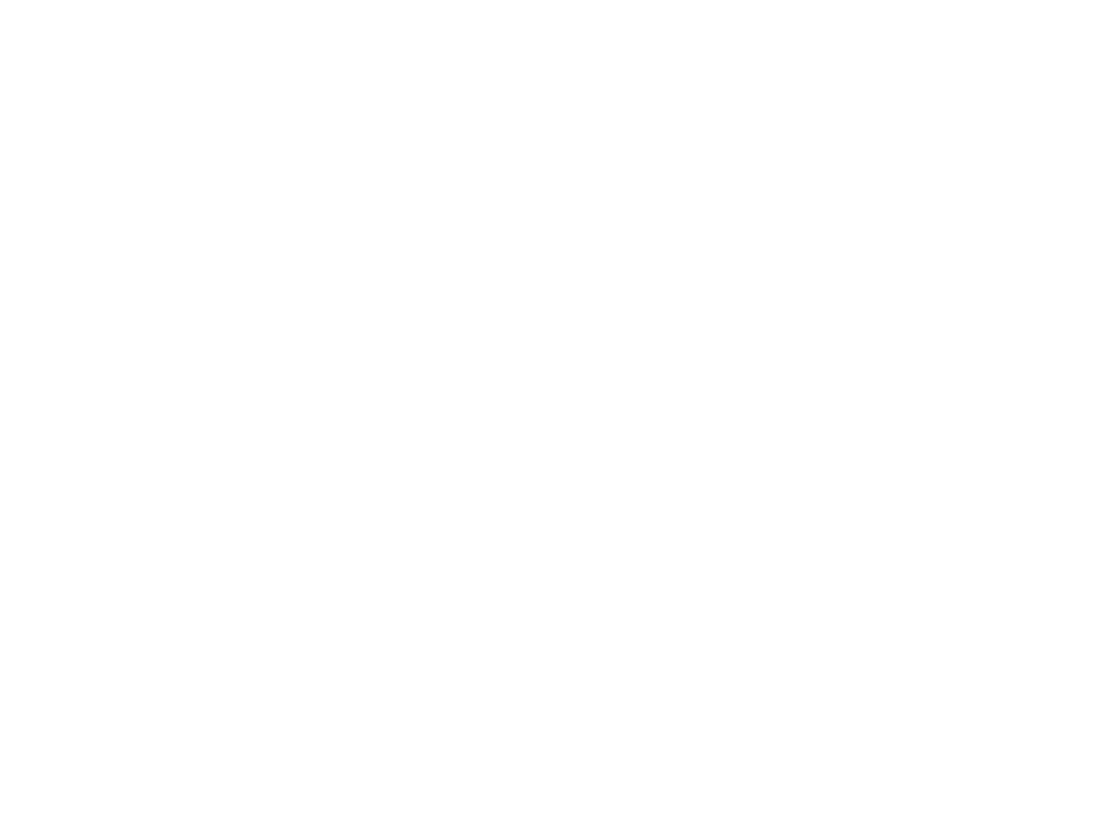

In [7]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

In [8]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=38

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



x=x[1:]
y=y[1:]
t=t[1:]

#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
#print(len(id1))
#id2=id2[id1!=1]
#id1=id1[id1!=1]

w=w/np.max(w)


xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i])
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

#plt.savefig('./TimeGraph.png',dpi=my_dpi,transparent=False) 

<IPython.core.display.Javascript object>

1.0 4.0
[0.10951903807615229, 0.3052073438327467]
1.0 5.0
[0.10951903807615229, 0.1970190380761523]
1.0 6.0
[0.10951903807615229, 0.6273882777720947]
1.0 7.0
[0.10951903807615229, 0.561122244488978]
2.0 4.0
[0.6776553106212425, 0.3052073438327467]
2.0 5.0
[0.6776553106212425, 0.1970190380761523]
2.0 6.0
[0.6776553106212425, 0.6273882777720947]
2.0 7.0
[0.6776553106212425, 0.561122244488978]
3.0 4.0
[0.28987975951903805, 0.3052073438327467]
3.0 5.0
[0.28987975951903805, 0.1970190380761523]
3.0 6.0
[0.28987975951903805, 0.6273882777720947]
3.0 7.0
[0.28987975951903805, 0.561122244488978]
4.0 8.0
[0.3052073438327467, 0.3481968027498594]
4.0 9.0
[0.3052073438327467, 0.23157282657040865]
4.0 10.0
[0.3052073438327467, 0.6214238299229097]
5.0 8.0
[0.1970190380761523, 0.3481968027498594]
5.0 9.0
[0.1970190380761523, 0.23157282657040865]
5.0 10.0
[0.1970190380761523, 0.6214238299229097]
6.0 8.0
[0.6273882777720947, 0.3481968027498594]
6.0 9.0
[0.6273882777720947, 0.23157282657040865]
6.0 10.0
[

50.0 57.0
[0.4434289954244987, 0.5491334838262791]
50.0 58.0
[0.4434289954244987, 0.4392284847008062]
50.0 59.0
[0.4434289954244987, 0.35332411343081316]
51.0 53.0
[0.531026618792682, 0.27055853013096276]
51.0 54.0
[0.531026618792682, 0.42811384190840873]
51.0 55.0
[0.531026618792682, 0.5234008946084584]
51.0 56.0
[0.531026618792682, 0.47719275800222816]
51.0 57.0
[0.531026618792682, 0.5491334838262791]
51.0 58.0
[0.531026618792682, 0.4392284847008062]
51.0 59.0
[0.531026618792682, 0.35332411343081316]
52.0 53.0
[0.47873472408470413, 0.27055853013096276]
52.0 54.0
[0.47873472408470413, 0.42811384190840873]
52.0 55.0
[0.47873472408470413, 0.5234008946084584]
52.0 56.0
[0.47873472408470413, 0.47719275800222816]
52.0 57.0
[0.47873472408470413, 0.5491334838262791]
52.0 58.0
[0.47873472408470413, 0.4392284847008062]
52.0 59.0
[0.47873472408470413, 0.35332411343081316]
53.0 60.0
[0.27055853013096276, 0.5911376967480934]
53.0 61.0
[0.27055853013096276, 0.4031708614003329]
53.0 62.0
[0.2705585

85.0 96.0
[0.6252931530338027, 0.2724280004147758]
85.0 97.0
[0.6252931530338027, 0.3784082028507493]
85.0 98.0
[0.6252931530338027, 0.3661379639313886]
85.0 99.0
[0.6252931530338027, 0.6162804445628592]
85.0 100.0
[0.6252931530338027, 0.4550763633741769]
85.0 101.0
[0.6252931530338027, 0.6533913784650935]
86.0 94.0
[0.391826801258628, 0.5592783160574784]
86.0 95.0
[0.391826801258628, 0.4406344686329594]
86.0 96.0
[0.391826801258628, 0.2724280004147758]
86.0 97.0
[0.391826801258628, 0.3784082028507493]
86.0 98.0
[0.391826801258628, 0.3661379639313886]
86.0 99.0
[0.391826801258628, 0.6162804445628592]
86.0 100.0
[0.391826801258628, 0.4550763633741769]
86.0 101.0
[0.391826801258628, 0.6533913784650935]
87.0 94.0
[0.2787497292601962, 0.5592783160574784]
87.0 95.0
[0.2787497292601962, 0.4406344686329594]
87.0 96.0
[0.2787497292601962, 0.2724280004147758]
87.0 97.0
[0.2787497292601962, 0.3784082028507493]
87.0 98.0
[0.2787497292601962, 0.3661379639313886]
87.0 99.0
[0.2787497292601962, 0.61

108.0 118.0
[0.5790983059704498, 0.6067097152239707]
108.0 119.0
[0.5790983059704498, 0.44070585968033565]
108.0 120.0
[0.5790983059704498, 0.4626358125578572]
108.0 121.0
[0.5790983059704498, 0.5012328068257101]
109.0 112.0
[0.5976358874485225, 0.4729458917835671]
109.0 113.0
[0.5976358874485225, 0.4812512188243841]
109.0 114.0
[0.5976358874485225, 0.31688177637340575]
109.0 115.0
[0.5976358874485225, 0.209186823556088]
109.0 116.0
[0.5976358874485225, 0.6641575646961132]
109.0 117.0
[0.5976358874485225, 0.40321096060005646]
109.0 118.0
[0.5976358874485225, 0.6067097152239707]
109.0 119.0
[0.5976358874485225, 0.44070585968033565]
109.0 120.0
[0.5976358874485225, 0.4626358125578572]
109.0 121.0
[0.5976358874485225, 0.5012328068257101]
110.0 112.0
[0.13827655310621242, 0.4729458917835671]
110.0 113.0
[0.13827655310621242, 0.4812512188243841]
110.0 114.0
[0.13827655310621242, 0.31688177637340575]
110.0 115.0
[0.13827655310621242, 0.209186823556088]
110.0 116.0
[0.13827655310621242, 0.664

135.0 149.0
[0.44779583017239005, 0.49543172546963]
135.0 150.0
[0.44779583017239005, 0.19096914058853287]
135.0 151.0
[0.44779583017239005, 0.7217341860835387]
135.0 152.0
[0.44779583017239005, 0.35818934220091947]
135.0 153.0
[0.44779583017239005, 0.43858848154116253]
135.0 154.0
[0.44779583017239005, 0.5041710343997632]
136.0 142.0
[0.5276715940891081, 0.447729255662313]
136.0 143.0
[0.5276715940891081, 0.7454909819639278]
136.0 144.0
[0.5276715940891081, 0.5403167542618929]
136.0 145.0
[0.5276715940891081, 0.5591448357672342]
136.0 146.0
[0.5276715940891081, 0.20242328491003145]
136.0 147.0
[0.5276715940891081, 0.3756106984676062]
136.0 148.0
[0.5276715940891081, 0.3010085231880187]
136.0 149.0
[0.5276715940891081, 0.49543172546963]
136.0 150.0
[0.5276715940891081, 0.19096914058853287]
136.0 151.0
[0.5276715940891081, 0.7217341860835387]
136.0 152.0
[0.5276715940891081, 0.35818934220091947]
136.0 153.0
[0.5276715940891081, 0.43858848154116253]
136.0 154.0
[0.5276715940891081, 0.504

156.0 174.0
[0.5290055016641382, 0.2703102886981366]
156.0 175.0
[0.5290055016641382, 0.3184090185048421]
156.0 176.0
[0.5290055016641382, 0.4921950296478512]
156.0 177.0
[0.5290055016641382, 0.5776613601134316]
156.0 178.0
[0.5290055016641382, 0.5785783715790735]
156.0 179.0
[0.5290055016641382, 0.3565995291831346]
156.0 180.0
[0.5290055016641382, 0.24460565670975332]
156.0 181.0
[0.5290055016641382, 0.44248172083325055]
156.0 182.0
[0.5290055016641382, 0.5441956646475079]
157.0 169.0
[0.20755661186330396, 0.708338380966925]
157.0 170.0
[0.20755661186330396, 0.29363047713296864]
157.0 171.0
[0.20755661186330396, 0.19368467095387737]
157.0 172.0
[0.20755661186330396, 0.35630515408490865]
157.0 173.0
[0.20755661186330396, 0.33811627032416364]
157.0 174.0
[0.20755661186330396, 0.2703102886981366]
157.0 175.0
[0.20755661186330396, 0.3184090185048421]
157.0 176.0
[0.20755661186330396, 0.4921950296478512]
157.0 177.0
[0.20755661186330396, 0.5776613601134316]
157.0 178.0
[0.20755661186330396

175.0 195.0
[0.3184090185048421, 0.22148716547732797]
175.0 196.0
[0.3184090185048421, 0.457795483769956]
175.0 197.0
[0.3184090185048421, 0.40559345992246904]
175.0 198.0
[0.3184090185048421, 0.6120892209327038]
175.0 199.0
[0.3184090185048421, 0.8476953907815631]
176.0 183.0
[0.4921950296478512, 0.18602157227149727]
176.0 184.0
[0.4921950296478512, 0.6737196333352139]
176.0 185.0
[0.4921950296478512, 0.5864638517408645]
176.0 186.0
[0.4921950296478512, 0.34106051052295394]
176.0 187.0
[0.4921950296478512, 0.5378408944939882]
176.0 188.0
[0.4921950296478512, 0.7849203312071985]
176.0 189.0
[0.4921950296478512, 0.4365464358059895]
176.0 190.0
[0.4921950296478512, 0.3425021050175868]
176.0 191.0
[0.4921950296478512, 0.3503783377751306]
176.0 192.0
[0.4921950296478512, 0.21890249926870675]
176.0 193.0
[0.4921950296478512, 0.32333533900186434]
176.0 194.0
[0.4921950296478512, 0.5460810970894722]
176.0 195.0
[0.4921950296478512, 0.22148716547732797]
176.0 196.0
[0.4921950296478512, 0.45779

184.0 214.0
[0.6737196333352139, 0.5911014544753204]
184.0 215.0
[0.6737196333352139, 0.3146530448972615]
185.0 200.0
[0.5864638517408645, 0.33868127279605337]
185.0 201.0
[0.5864638517408645, 0.2714808156243251]
185.0 202.0
[0.5864638517408645, 0.1593619343918399]
185.0 203.0
[0.5864638517408645, 0.3220777373101601]
185.0 204.0
[0.5864638517408645, 0.5147950580098579]
185.0 205.0
[0.5864638517408645, 0.823603885915097]
185.0 206.0
[0.5864638517408645, 0.20479516985664156]
185.0 207.0
[0.5864638517408645, 0.4432486056767156]
185.0 208.0
[0.5864638517408645, 0.6811973125156587]
185.0 209.0
[0.5864638517408645, 0.6703073919273769]
185.0 210.0
[0.5864638517408645, 0.4529959492694411]
185.0 211.0
[0.5864638517408645, 0.2277951624519853]
185.0 212.0
[0.5864638517408645, 0.40985624658844466]
185.0 213.0
[0.5864638517408645, 0.6330383885366029]
185.0 214.0
[0.5864638517408645, 0.5911014544753204]
185.0 215.0
[0.5864638517408645, 0.3146530448972615]
186.0 200.0
[0.34106051052295394, 0.33868127

199.0 213.0
[0.8476953907815631, 0.6330383885366029]
199.0 214.0
[0.8476953907815631, 0.5911014544753204]
199.0 215.0
[0.8476953907815631, 0.3146530448972615]
200.0 216.0
[0.33868127279605337, 0.024048096192384766]
200.0 217.0
[0.33868127279605337, 0.37080890152490137]
200.0 218.0
[0.33868127279605337, 0.10795561950974678]
200.0 219.0
[0.33868127279605337, 0.28708207249634976]
200.0 220.0
[0.33868127279605337, 0.5179792225686604]
200.0 221.0
[0.33868127279605337, 0.8299364545046547]
200.0 222.0
[0.33868127279605337, 0.3198507118039118]
200.0 223.0
[0.33868127279605337, 0.4305304530659689]
200.0 224.0
[0.33868127279605337, 0.5284643273007565]
200.0 225.0
[0.33868127279605337, 0.189195027671835]
200.0 226.0
[0.33868127279605337, 0.633536950769851]
200.0 227.0
[0.33868127279605337, 0.3353390893028443]
200.0 228.0
[0.33868127279605337, 0.6060107638820678]
200.0 229.0
[0.33868127279605337, 0.6626498151693319]
200.0 230.0
[0.33868127279605337, 0.2403790617218563]
200.0 231.0
[0.3386812727960

214.0 234.0
[0.5911014544753204, 0.8216432865731462]
215.0 216.0
[0.3146530448972615, 0.024048096192384766]
215.0 217.0
[0.3146530448972615, 0.37080890152490137]
215.0 218.0
[0.3146530448972615, 0.10795561950974678]
215.0 219.0
[0.3146530448972615, 0.28708207249634976]
215.0 220.0
[0.3146530448972615, 0.5179792225686604]
215.0 221.0
[0.3146530448972615, 0.8299364545046547]
215.0 222.0
[0.3146530448972615, 0.3198507118039118]
215.0 223.0
[0.3146530448972615, 0.4305304530659689]
215.0 224.0
[0.3146530448972615, 0.5284643273007565]
215.0 225.0
[0.3146530448972615, 0.189195027671835]
215.0 226.0
[0.3146530448972615, 0.633536950769851]
215.0 227.0
[0.3146530448972615, 0.3353390893028443]
215.0 228.0
[0.3146530448972615, 0.6060107638820678]
215.0 229.0
[0.3146530448972615, 0.6626498151693319]
215.0 230.0
[0.3146530448972615, 0.2403790617218563]
215.0 231.0
[0.3146530448972615, 0.5090476843361776]
215.0 232.0
[0.3146530448972615, 0.6634556009685342]
215.0 233.0
[0.3146530448972615, 0.44437026

231.0 244.0
[0.5090476843361776, 0.3956586181393788]
231.0 245.0
[0.5090476843361776, 0.3686738350247204]
231.0 246.0
[0.5090476843361776, 0.43105917256083565]
231.0 247.0
[0.5090476843361776, 0.841880600664408]
231.0 248.0
[0.5090476843361776, 0.5003139057563771]
231.0 249.0
[0.5090476843361776, 0.6037293213885354]
231.0 250.0
[0.5090476843361776, 0.1686603641495003]
231.0 251.0
[0.5090476843361776, 0.36491471776203804]
232.0 235.0
[0.6634556009685342, 0.504276675354777]
232.0 236.0
[0.6634556009685342, 0.6425434773061899]
232.0 237.0
[0.6634556009685342, 0.5562947159805609]
232.0 238.0
[0.6634556009685342, 0.26439855233231085]
232.0 239.0
[0.6634556009685342, 0.7123854556091629]
232.0 240.0
[0.6634556009685342, 0.12719523544725048]
232.0 241.0
[0.6634556009685342, 0.7093468637029207]
232.0 242.0
[0.6634556009685342, 0.18515663409031136]
232.0 243.0
[0.6634556009685342, 0.4507056799684008]
232.0 244.0
[0.6634556009685342, 0.3956586181393788]
232.0 245.0
[0.6634556009685342, 0.36867383

246.0 266.0
[0.43105917256083565, 0.42332755175450776]
246.0 267.0
[0.43105917256083565, 0.6357906403662954]
246.0 268.0
[0.43105917256083565, 0.11408952830782554]
246.0 269.0
[0.43105917256083565, 0.7061751335460438]
246.0 270.0
[0.43105917256083565, 0.3885344784761264]
246.0 271.0
[0.43105917256083565, 0.3525498450146906]
247.0 252.0
[0.841880600664408, 0.5118587403088392]
247.0 253.0
[0.841880600664408, 0.2323287926759854]
247.0 254.0
[0.841880600664408, 0.4553275376487884]
247.0 255.0
[0.841880600664408, 0.6265962867314675]
247.0 256.0
[0.841880600664408, 0.34163172919733487]
247.0 257.0
[0.841880600664408, 0.5552766636652833]
247.0 258.0
[0.841880600664408, 0.6634770658770874]
247.0 259.0
[0.841880600664408, 0.18176607128892522]
247.0 260.0
[0.841880600664408, 0.5551102204408818]
247.0 261.0
[0.841880600664408, 0.28456913827655306]
247.0 262.0
[0.841880600664408, 0.17999305766678256]
247.0 263.0
[0.841880600664408, 0.4575412061410632]
247.0 264.0
[0.841880600664408, 0.733330438988

261.0 285.0
[0.28456913827655306, 0.7121395813952288]
261.0 286.0
[0.28456913827655306, 0.41038773603815654]
261.0 287.0
[0.28456913827655306, 0.20077887475684572]
261.0 288.0
[0.28456913827655306, 0.6415380140399757]
261.0 289.0
[0.28456913827655306, 0.26550513567012574]
262.0 272.0
[0.17999305766678256, 0.3219062594380536]
262.0 273.0
[0.17999305766678256, 0.5041782171516727]
262.0 274.0
[0.17999305766678256, 0.885526514481324]
262.0 275.0
[0.17999305766678256, 0.7587667442097784]
262.0 276.0
[0.17999305766678256, 0.1263368249463144]
262.0 277.0
[0.17999305766678256, 0.34057429020760127]
262.0 278.0
[0.17999305766678256, 0.6265962867314675]
262.0 279.0
[0.17999305766678256, 0.1650543177107898]
262.0 280.0
[0.17999305766678256, 0.37540176841016976]
262.0 281.0
[0.17999305766678256, 0.5226237747410789]
262.0 282.0
[0.17999305766678256, 0.3941267244261566]
262.0 283.0
[0.17999305766678256, 0.4207867778275153]
262.0 284.0
[0.17999305766678256, 0.689631811037329]
262.0 285.0
[0.1799930576

In [9]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        print('ii',ii)
        print(prev_c)
        return prev_c[int(ii-2)],False
    if id1==1:
        return 'black',True
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0],False
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id=id[1:]
tt=tt[1:]
id_f=[2,3,4]


print(c[id_f==1])


    


for t in range(31):
    
        
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf,rec=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        if rec:
            rec1=plt.Rectangle((x_n,y_n), r_n, r_n,fc=c_cf,ec=c_cf) 
            ax.add_patch(rec1)
        else:
            circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
            ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

blue


<IPython.core.display.Javascript object>

c_full ['blue', 'green', 'violet']
ii 2.0
['blue', 'green', 'violet']
ii 3.0
['blue', 'green', 'violet']


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)